# 1.迁移学习
现在已经有很很多优秀的神经网络模型，这些模型大部分都是使用ImageNet数据集1000类训练得到的

然而在实际应用中1000类的模型并不完全适用自己的数据集

而使用自己的数据集训练需要花费大量的计算时间，而且有可能数据不够无法得到理想的模型

这时候可以保留训练好的模型的大部分参数，而仅仅对网络的最后几层全连接层进行Finetuning

这里将适用猫狗大战数据集中的1500张图对VGG16网络的最后三层全连接层进行训练

因为最后输出只有两类，所有将最后一层全连接层输出维度改为2


迁移学习的效果：
- 所需样本数量更少
- 模型达到收敛所需耗时更短

# 2. 数据读取
Cats vs. Dogs（猫狗大战）来源于Kaggle上的一个竞赛
利用给定的数据集，用算法实现猫和狗的识别

数据集由训练数据和测试数据组成：
- 训练数据包含猫和狗各12500张图片
- 测试数据包含12500张猫和狗的图片

猫狗大战的数据集下载地址： http://www.kaggle.com/c/dogs-vs-cats

因为官方数据集下载需要帐号

所以把数据集上传到了百度网盘：https://pan.baidu.com/s/1RxQSCqbMaP4bLYU762MhtQ  （提取码：gjk0）方便下载

下载后解压`test1.zip`和`train.zip`即可

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
from PIL import Image

train_file_dir = '../data/kaggle/train/'
test_file_dir = '../data/kaggle/test1/'


def get_file(file_dir):
    images = []
    for root, sub_folders, files in os.walk(file_dir):
        for name in files:
            images.append(os.path.join(root, name))
    labels = []
    for name in files:
        letter = name.split("/")[-1].split('.')[0]
        if letter == 'cat':
            labels.append(0)
        else:
            labels.append(1)
    # shuffle
    temp = np.array([images, labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(float(i)) for i in label_list]
    return image_list, label_list


def onehot(labels):
    n_sample = len(labels)
    n_class = max(labels) + 1
    onehot_labels = np.zeros((n_sample, n_class))
    onehot_labels[np.arange(n_sample), labels] = 1
    return onehot_labels


Xtrain, Ytrain = get_file(train_file_dir)

查看数据大小

In [2]:
print('training data shape:', len(Xtrain))
print('training labels shape:', len(Ytrain))

training data shape: 25000
training labels shape: 25000


# 3. 构建模型


In [3]:
# 定义训练数据的占位符， x是224*224*3个像素点的特征值， y是2分类的标签值
x = tf.placeholder(tf.float32, [None, 224, 224, 3], name="X")
y = tf.placeholder(tf.float32, [None, 2], name="Y")


class vgg16:
    def __init__(self, imgs):
        self.parameters = []  # 类的初始化加入全局列表，将所需共享的参数加载进来
        self.imgs = imgs
        self.convlayers()
        self.fc_layers()
        self.forward = self.fc8
        self.pred = tf.nn.softmax(self.fc8)

    def saver(self):
        return tf.train.Saver()

    def maxpool(self, name, input_data, trainable):
        out = tf.nn.max_pool(input_data, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME", name=name)
        return out

    def conv(self, name, input_data, out_channel, trainable):
        in_channel = input_data.get_shape()[-1]
        with tf.variable_scope(name):
            kernel = tf.get_variable("weights", [3, 3, in_channel, out_channel], dtype=tf.float32, trainable=False)
            biases = tf.get_variable("biases", [out_channel], dtype=tf.float32, trainable=False)
            conv_res = tf.nn.conv2d(input_data, kernel, [1, 1, 1, 1], padding="SAME")
            res = tf.nn.bias_add(conv_res, biases)
            out = tf.nn.relu(res, name=name)
        self.parameters += [kernel, biases]
        return out

    def fc(self, name, input_data, out_channel, trainable=True):
        shape = input_data.get_shape().as_list()
        if len(shape) == 4:
            size = shape[-1] * shape[-2] * shape[-3]
        else:
            size = shape[1]
        input_data_flat = tf.reshape(input_data, [-1, size])
        with tf.variable_scope(name):
            weights = tf.get_variable(name="weights", shape=[size, out_channel], dtype=tf.float32, trainable=trainable)
            biases = tf.get_variable(name="biases", shape=[out_channel], dtype=tf.float32, trainable=trainable)
            res = tf.matmul(input_data_flat, weights)
            out = tf.nn.relu(tf.nn.bias_add(res, biases))
        self.parameters += [weights, biases]
        return out

    def convlayers(self):
        # conv1
        self.conv1_1 = self.conv("conv1re_1", self.imgs, 64, trainable=False)
        self.conv1_2 = self.conv("conv1_2", self.conv1_1, 64, trainable=False)
        self.pool1 = self.maxpool("poolre1", self.conv1_2, trainable=False)

        # conv2
        self.conv2_1 = self.conv("conv2_1", self.pool1, 128, trainable=False)
        self.conv2_2 = self.conv("convwe2_2", self.conv2_1, 128, trainable=False)
        self.pool2 = self.maxpool("pool2", self.conv2_2, trainable=False)

        # conv3
        self.conv3_1 = self.conv("conv3_1", self.pool2, 256, trainable=False)
        self.conv3_2 = self.conv("convrwe3_2", self.conv3_1, 256, trainable=False)
        self.conv3_3 = self.conv("convrew3_3", self.conv3_2, 256, trainable=False)
        self.pool3 = self.maxpool("poolre3", self.conv3_3, trainable=False)

        # conv4
        self.conv4_1 = self.conv("conv4_1", self.pool3, 512, trainable=False)
        self.conv4_2 = self.conv("convrwe4_2", self.conv4_1, 512, trainable=False)
        self.conv4_3 = self.conv("conv4rwe_3", self.conv4_2, 512, trainable=False)
        self.pool4 = self.maxpool("pool4", self.conv4_3, trainable=False)

        # conv5
        self.conv5_1 = self.conv("conv5_1", self.pool4, 512, trainable=False)
        self.conv5_2 = self.conv("convrwe5_2", self.conv5_1, 512, trainable=False)
        self.conv5_3 = self.conv("conv5_3", self.conv5_2, 512, trainable=False)
        self.pool5 = self.maxpool("poorwel5", self.conv5_3, trainable=False)

    def fc_layers(self):
        self.fc6 = self.fc("fc6", self.pool5, 4096)
        self.fc7 = self.fc("fc7", self.fc6, 4096)
        self.fc8 = self.fc("fc8", self.fc7, 2)

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i not in [30, 31]:
                sess.run(self.parameters[i].assign(weights[k]))
        print("Finished loading vgg16_weights")


# 运行vgg16模型计算
vgg = vgg16(x)

# 获得模型输出期望
forward = vgg.forward
pred = vgg.pred

# 定义损失函数
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=forward, labels=y))

W0807 14:18:24.646687 14208 deprecation.py:506] From C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 14:18:24.894994 14208 deprecation.py:323] From <ipython-input-3-ec2c46469292>:100: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# 4. 训练模型

In [4]:
train_epochs = 10  # 设置迭代次数
learning_rate = 0.0001  # 学习率

# 梯度下降优化器 设置学习率和优化目标损失最小化
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function)

# 定义预测类别匹配情况
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# 定义准确率，将布尔值转化成浮点数，再求平均值
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

sess = tf.Session()  # 建立会话
sess.run(tf.global_variables_initializer())

# 定义保存模型
saver = vgg.saver()
save_dir = "../save_path/VGG16/"

save_step = 0  # 定义保存模型编号
# 恢复保存模型
ckpt_dir = tf.train.latest_checkpoint(save_dir)
if ckpt_dir != None:
    # 恢复训练保存的模型
    saver.restore(sess, ckpt_dir)
    print("Finished loading", ckpt_dir)
    save_step = int(input("Set the load save step:"))
else:
    # 输入VGG16权重
    weight_file = '../save_path/vgg16_weights.npz'
    vgg.load_weights(weight_file, sess)


def get_batch(image_list, label_list, img_width, img_height, batch_size, capacity):
    image = tf.cast(image_list, tf.string)
    label = tf.cast(label_list, tf.int32)

    input_queue = tf.train.slice_input_producer([image, label])

    label = input_queue[1]
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)

    image = tf.image.resize_image_with_crop_or_pad(image, img_width, img_height)
    image = tf.image.per_image_standardization(image)  # 将图片标准化
    image_batch, label_batch = tf.train.batch([image, label], batch_size=batch_size, num_threads=64, capacity=capacity)
    label_batch = tf.reshape(label_batch, [batch_size])

    return image_batch, label_batch


# 每个批次的大小，每次放入的大小，每次放入 64张图片 以矩阵的方式
batch_size = 64

# 内存中存储的最大数据容量
capacity = 256

# VGG训练时图像预处理所减均值(RGB三通道)
means = [123.68, 116.779, 103.939]

image_batch, label_batch = get_batch(Xtrain, Ytrain, 224, 224, batch_size, capacity)

coord = tf.train.Coordinator()  # 使用协调器Coordinator来管理程
threads = tf.train.start_queue_runners(coord=coord, sess=sess)

for epoch in range(0, train_epochs):

    image, label = sess.run([image_batch, label_batch])
    labels = onehot(label)

    sess.run(optimizer, feed_dict={x: image, y: labels})

    if (epoch + 1) % 10 == 0: 
        loss, acc = sess.run([loss_function, accuracy], feed_dict={x: image, y: labels})
        # 显示训练信息
        print("TrainEpoch=", '%04d' % (epoch + 1), "Loss=", '{:.6f}'.format(loss), "Accuracy=", "{:.3f}".format(acc))
        save_step += 1
        save_path = saver.save(sess, save_dir + "model", global_step=save_step)

coord.request_stop()  # 通知其他线程关闭
coord.join(threads)  # join操作等待其他线程结束,其他所有线程关闭之后,这一函数才能返回

W0807 14:18:25.784526 14208 deprecation.py:323] From C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Finished loading ../save_path/VGG16/model-49
Set the load save step:49


W0807 14:18:30.133608 14208 deprecation.py:323] From <ipython-input-4-1bcd974e605e>:38: slice_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0807 14:18:30.137216 14208 deprecation.py:323] From C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\training\input.py:374: range_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W0807 14:18:30.140207 14208 deprecation.py:323] From 

TrainEpoch= 0010 Loss= 0.150092 Accuracy= 0.984


# 5. 模型预测

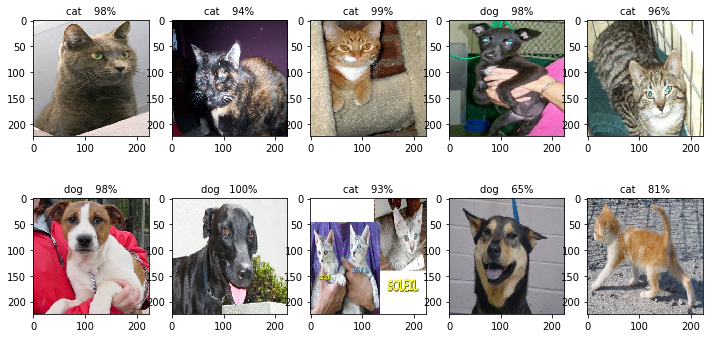

In [5]:
# 定义显示图像预测标签及其对应标签可能性的函数
def plot_images_labels_prediction(idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        test_file_path = '../data/kaggle/test1/{0}.jpg'.format(idx + i)
        test_image = imageio.imread(test_file_path)
        test_image = np.array(Image.fromarray(test_image).resize((224, 224)))
        ax = plt.subplot(2, 5, 1 + i)
        ax.imshow(test_image, cmap="binary")
        test_image = test_image.astype(np.float)
        for c in range(3):
            test_image[:, c] -= means[c]
        test_pred = sess.run(pred, feed_dict={x: [test_image]})
        max_index = np.argmax(test_pred)
        if max_index == 0:
            title = "cat   %3.f%%" % (test_pred[:, 0] * 100)
        else:
            title = "dog   %3.f%%" % (test_pred[:, 1] * 100)
        ax.set_title(title, fontsize=10)
        idx += 1
    plt.show()


# 显示第11-20张图像预测标签及其对应标签可能性
plot_images_labels_prediction(11, 10)